In [47]:
import os
import math
import random 
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt 

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array,ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau


def tohum(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    
tohum(2002)

In [48]:
def load_images_from_folder(folder, image_file_column, folder_path):
    images = []
    for index, row in folder.iterrows():
        img_path = os.path.join(folder_path, row[image_file_column])
        try:
            img = load_img(img_path, target_size=(30, 30))
            img_array = img_to_array(img)
            images.append(img_array)
        except FileNotFoundError:
            print(f"File not found: {img_path}")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
    return np.array(images)


base_path = '/TraficSign/TraficLightDatasets'

meta_df = pd.read_csv(os.path.join(base_path, 'Meta.csv'))
test_df = pd.read_csv(os.path.join(base_path, 'Test.csv'))
train_df = pd.read_csv(os.path.join(base_path, 'Train.csv'))

X_train = load_images_from_folder(train_df, 'Path', base_path)
y_train = train_df['ClassId'].values 

print(f"Loaded {X_train.shape[0]} images for training.")

X_test = load_images_from_folder(test_df, 'Path', base_path)
y_test = test_df['ClassId'].values  

X_meta = load_images_from_folder(meta_df, 'Path', base_path)
y_meta = meta_df['ClassId'].values  

if X_train.shape[0] > 0 and len(y_train) > 0:
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
else:
    print("Training data or labels not loaded properly.")

X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

num_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

Loaded 39209 images for training.
(31367, 30, 30, 3) (12630, 30, 30, 3) (31367, 43) (12630, 43)


In [49]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(30, 30, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.15),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),    
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  loss='categorical_crossentropy',  metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)


model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, 
                                   monitor='val_loss', mode='min')

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [50]:
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=50, 
                    batch_size=128, 
                    callbacks=[early_stopping, model_checkpoint,lr_scheduler])

Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 23s 78ms/step - accuracy: 0.5550 - loss: 1.6568 - val_accuracy: 0.3731 - val_loss: 2.2415 - learning_rate: 0.0010
Epoch 2/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 16s 65ms/step - accuracy: 0.9504 - loss: 0.1627 - val_accuracy: 0.8985 - val_loss: 0.2954 - learning_rate: 0.0010
Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 16s 65ms/step - accuracy: 0.9776 - loss: 0.0727 - val_accuracy: 0.9805 - val_loss: 0.0604 - learning_rate: 0.0010
Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 16s 65ms/step - accuracy: 0.9837 - loss: 0.0494 - val_accuracy: 0.9828 - val_loss: 0.0570 - learning_rate: 0.0010
Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 19s 78ms/step - accuracy: 0.9884 - loss: 0.0334 - val_accuracy: 0.9907 - val_loss: 0.0305 - learning_rate: 0.0010
Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.9919 - loss: 0.0241 - val_accuracy: 0.9880 - val_loss: 0.0373 - learning_rate: 0.0010
Epoch 7/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.9899 - l

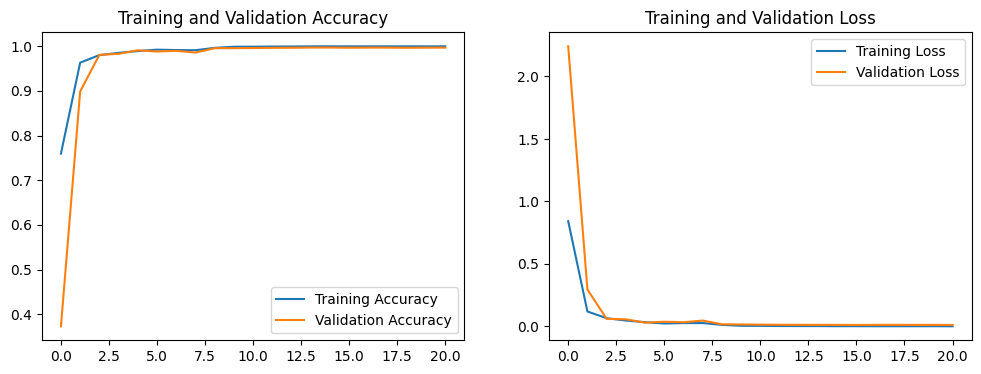

In [51]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))
    plt.figure(figsize=(12, 4))
    

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()
    
plot_history(history)

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


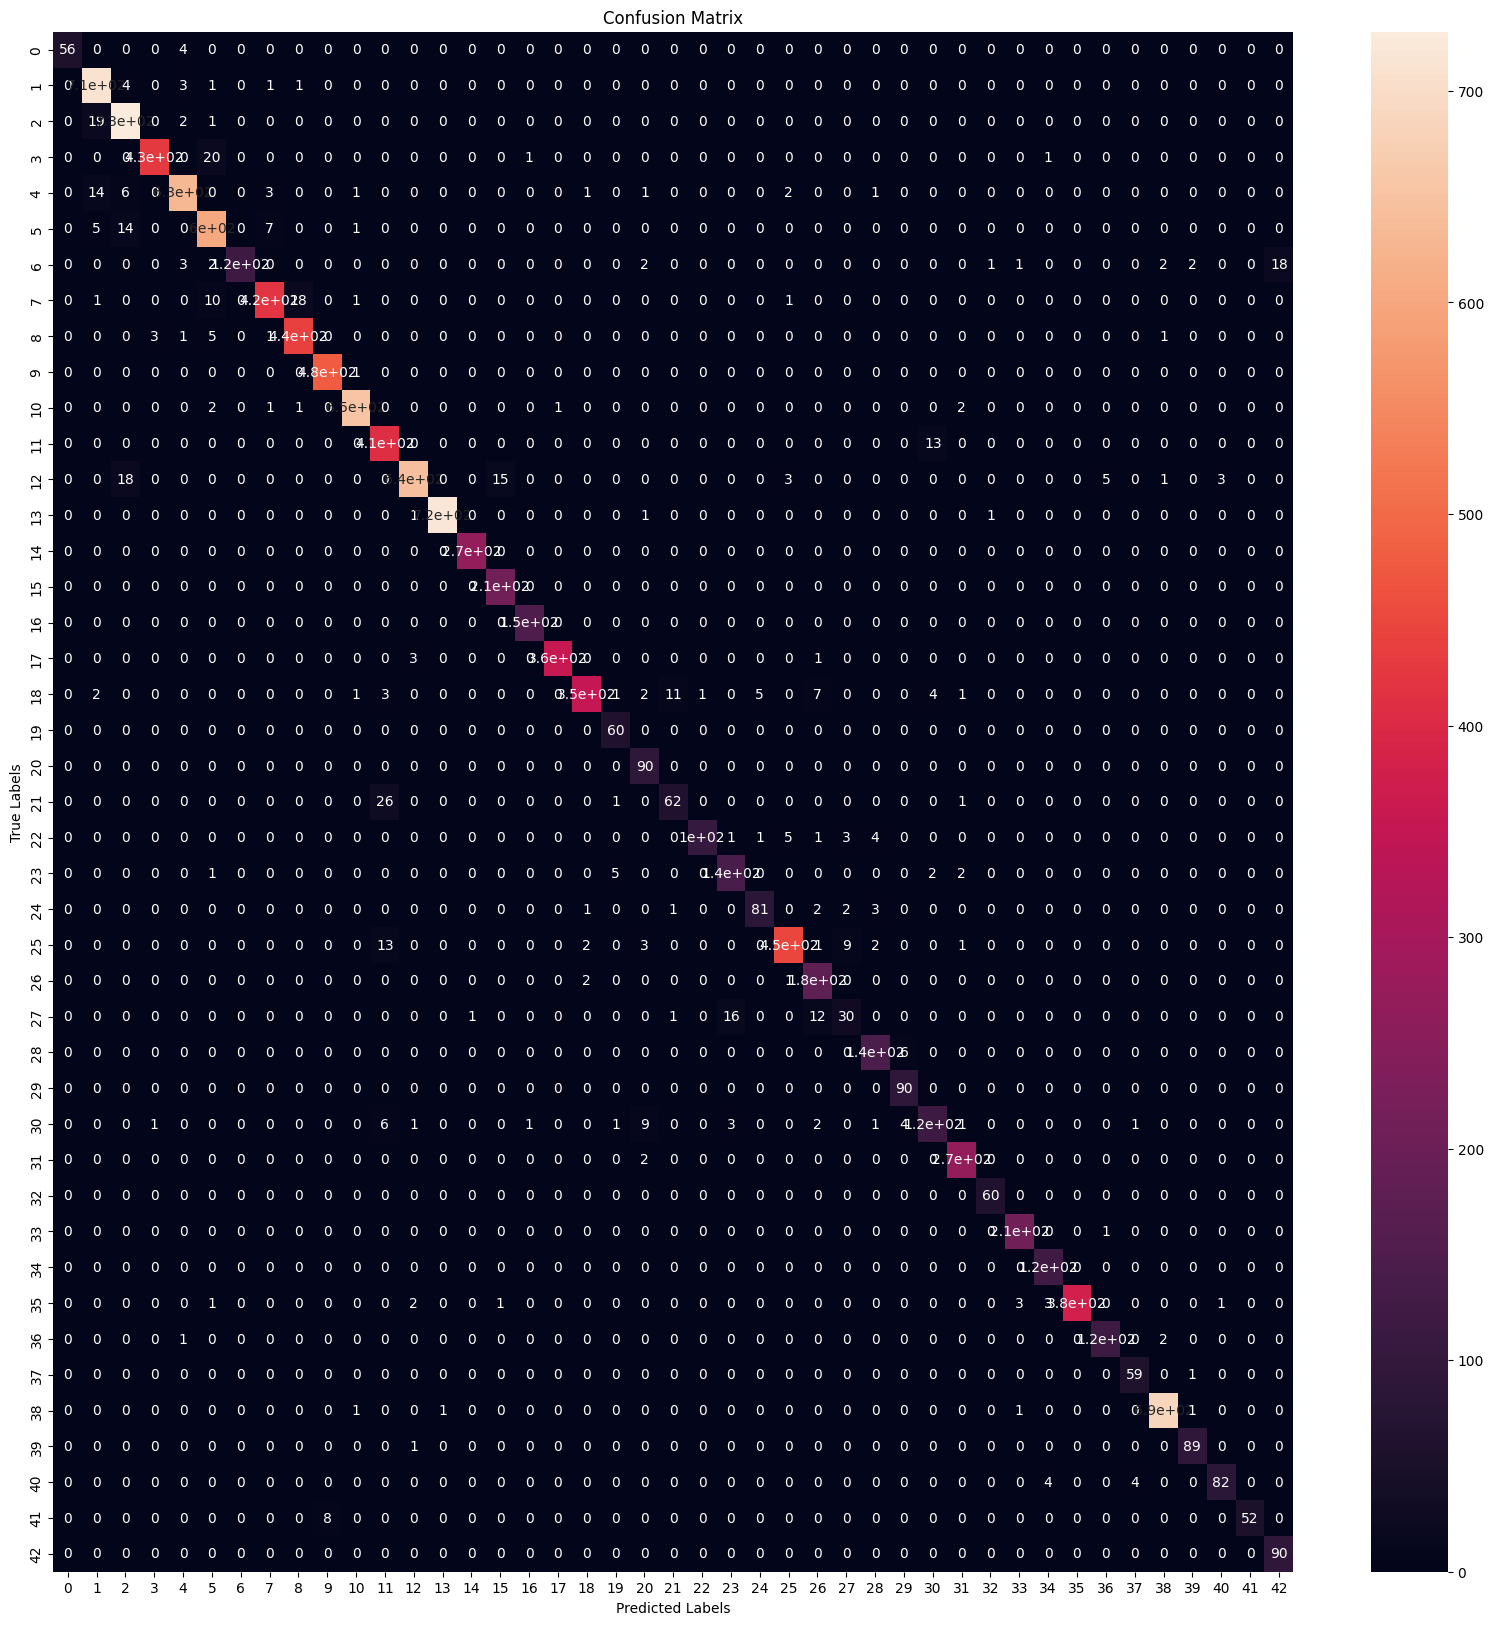

In [52]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)  

classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }


df_cm = pd.DataFrame(confusion_matrix(y_true, y_pred_classes), index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [53]:
print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=list(classes.values())))

Classification Report:
                                precision    recall  f1-score   support

         Speed limit (20km/h)       1.00      0.93      0.97        60
         Speed limit (30km/h)       0.95      0.99      0.97       720
         Speed limit (50km/h)       0.95      0.97      0.96       750
         Speed limit (60km/h)       0.99      0.95      0.97       450
         Speed limit (70km/h)       0.98      0.96      0.97       660
         Speed limit (80km/h)       0.93      0.96      0.95       630
  End of speed limit (80km/h)       1.00      0.79      0.88       150
        Speed limit (100km/h)       0.97      0.93      0.95       450
        Speed limit (120km/h)       0.96      0.98      0.97       450
                   No passing       0.98      1.00      0.99       480
 No passing veh over 3.5 tons       0.99      0.99      0.99       660
 Right-of-way at intersection       0.89      0.97      0.93       420
                Priority road       0.99      0.93  

In [54]:
model.load_weights('best_model.keras')

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")

395/395 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9590 - loss: 0.1605
Test accuracy: 0.9604117274284363, Test loss: 0.16382823884487152


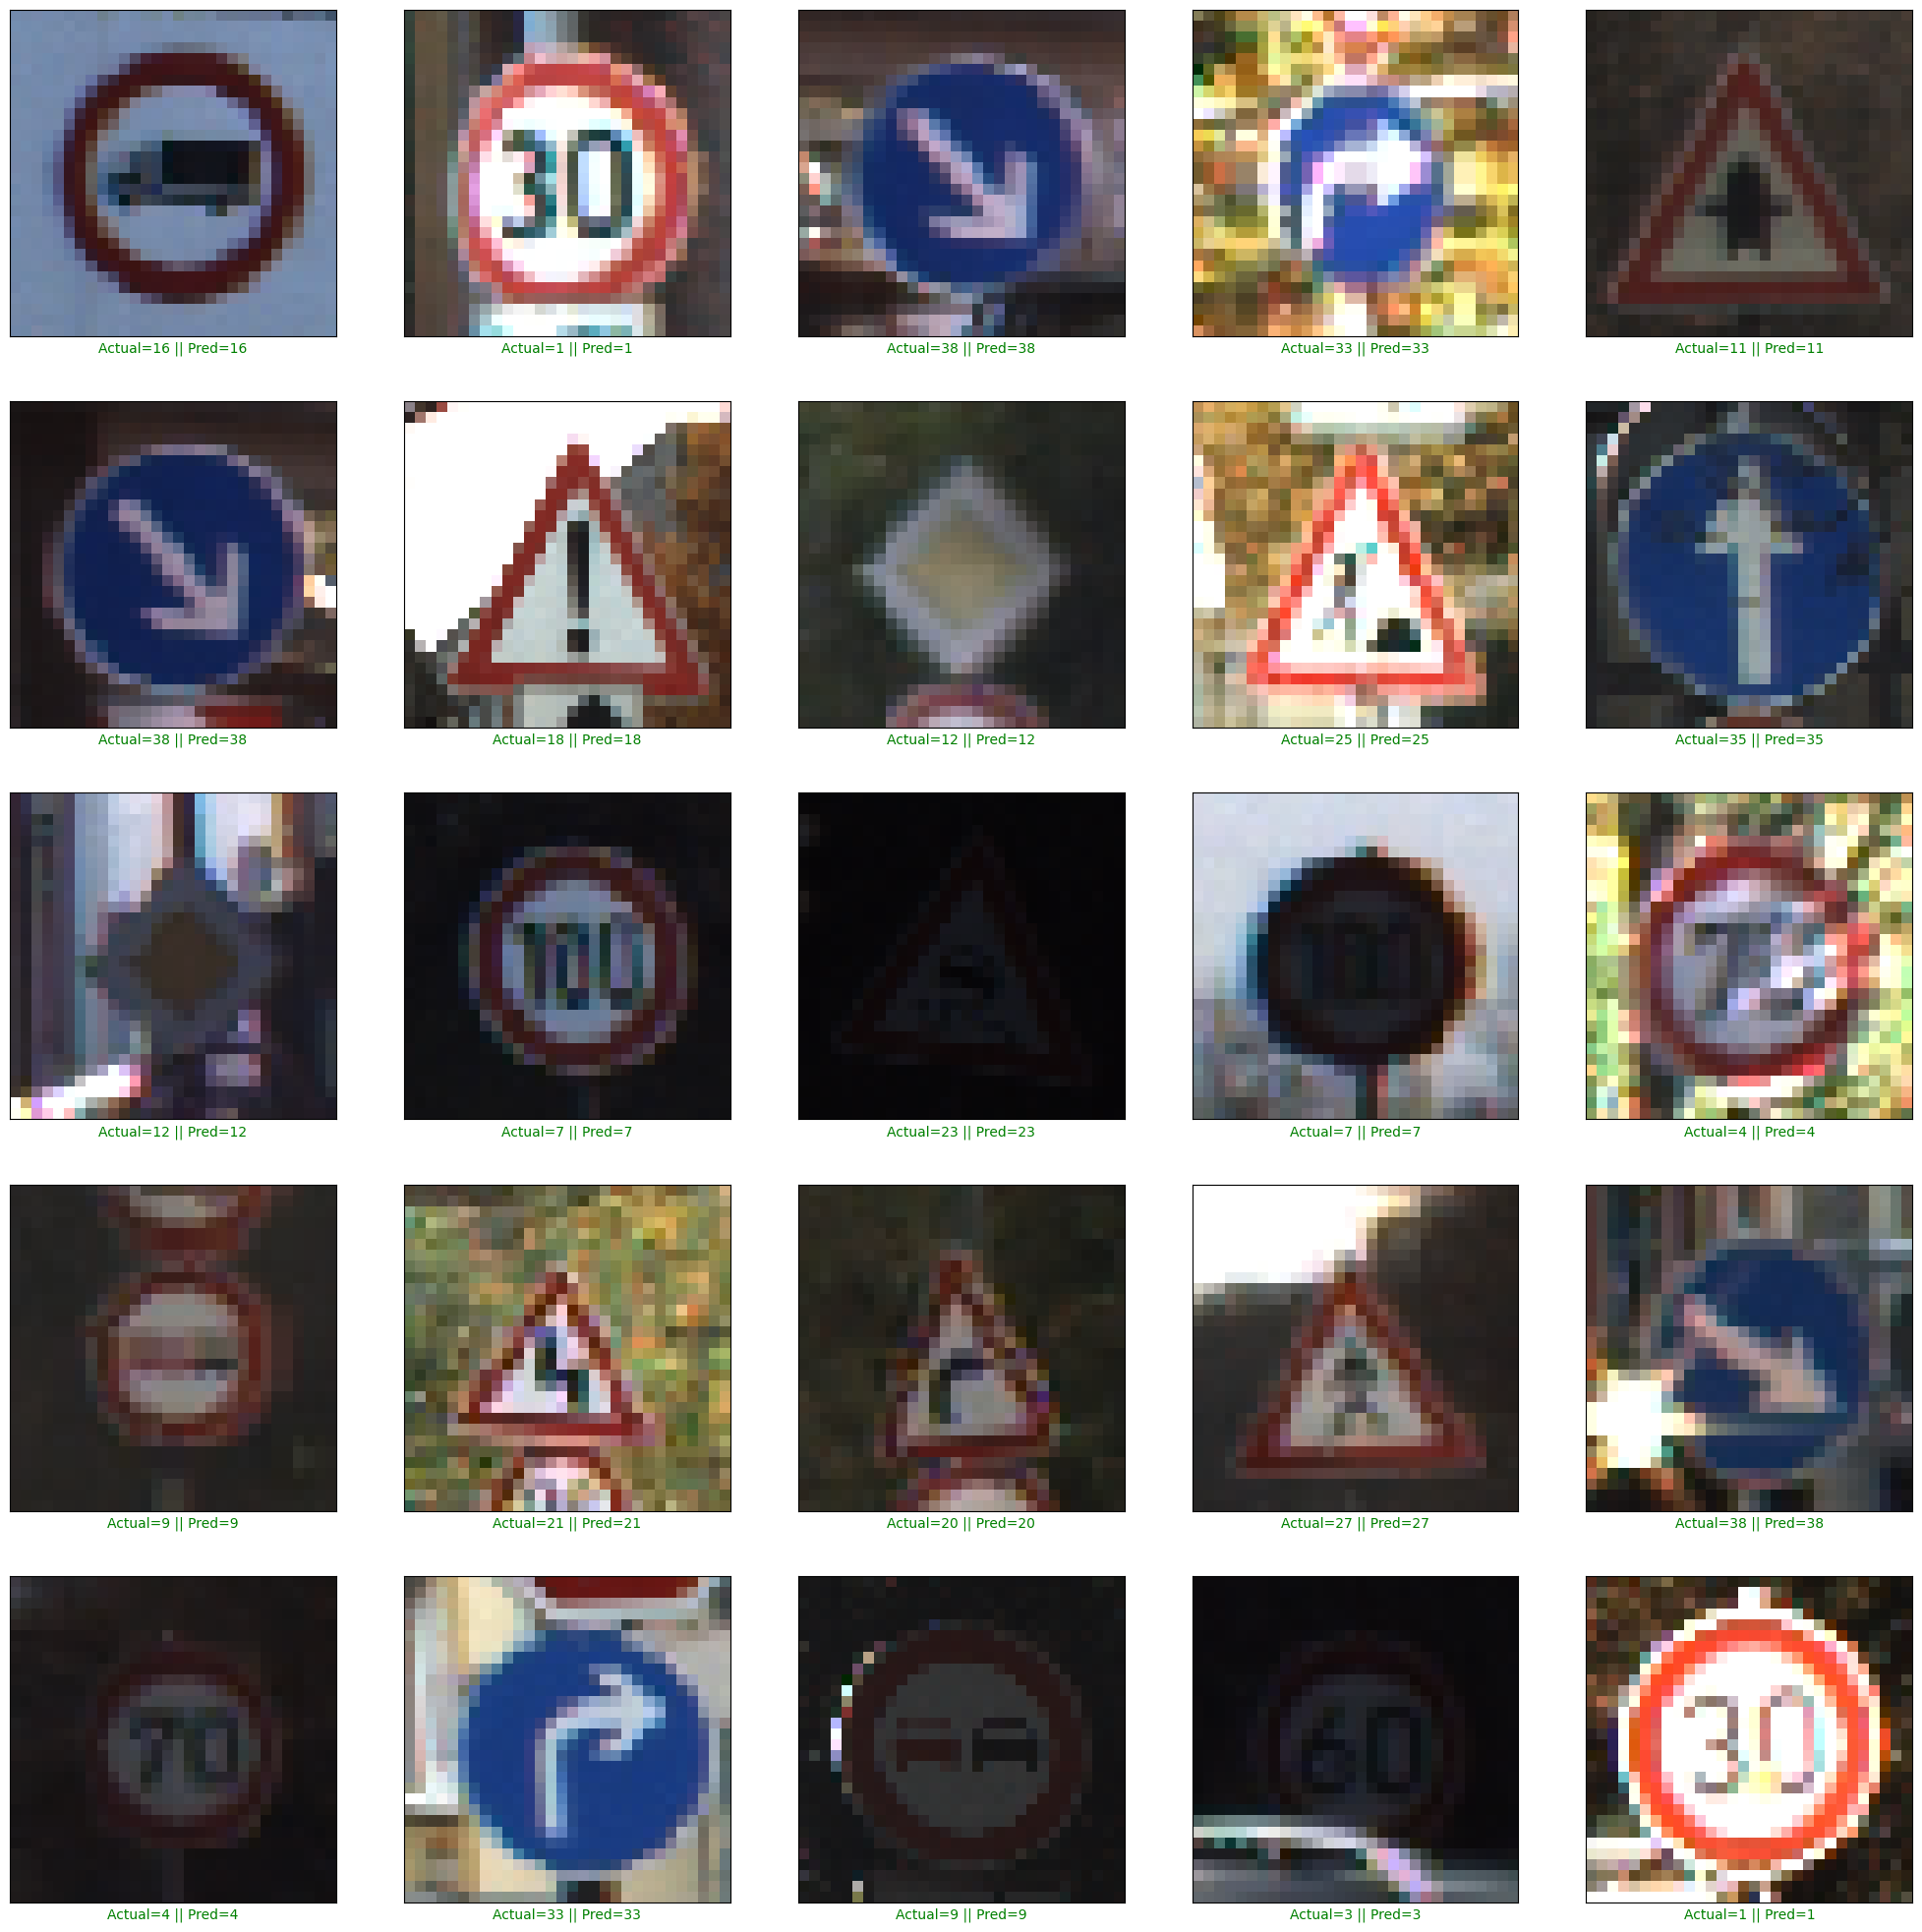

In [57]:
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = y_pred_classes[start_index + i]
    actual = y_true[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()